In [1]:
#! Overall task, to implement both RNN and LSTM on pytorch to perform
#! binary conversion according to 3-1_2-RNN_LSTM_Pytorch.ipynb. 
#! this time use files of : binary.npy as x, and decimal.npy as y. 

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls '/content/drive/My Drive/4º Curso/DeepLearning/DeepLearningLabs/Lab4/Publish/data/'
myDrive = '/content/drive/My Drive/4º Curso/DeepLearning/DeepLearningLabs/Lab4/Publish/data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
binary.npy   names	  Sales_store.csv
decimal.npy  RNN-SIN.pkl  Sales_store_mean.csv


## Reading the data:

Here we first read the data using numpy and we convert it to tensors.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using ", device)

# load and setup the data

binary = np.load(myDrive+'binary.npy')
decimal = np.load(myDrive+'decimal.npy')

x = torch.from_numpy(binary).float().unsqueeze(1).to(device)
print("Size of the input: ", x.size())
y = torch.from_numpy(decimal).float().unsqueeze(-1).to(device)
print("Size of the ground truth: ", y.size())

Using  cuda
Size of the input:  torch.Size([256, 1, 8])
Size of the ground truth:  torch.Size([256, 1, 1])


## RNN model
Our recurrent model uses the already implemented recurrent network by pytorch and then we add a FNN to make the regression. We decided to use a Sigmoid multiplied by 256 because we thought that using a ReLU would end up in large weights which would then saturate the gradient during training.

In [0]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN, self).__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(1, x.size(0), self.hidden_dim)).to(device)
        
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out)
        out = self.ReLU(out)
        return out

## Weight initialization


In [0]:
num_epoch = 4000

# Create RNN
input_dim = 8    # input dimension
hidden_dim = 8   # hidden layer dimension
layer_dim = 1    # number of hidden layers
output_dim = 1   # output dimension

#model = RNN(input_dim, hidden_dim, layer_dim, output_dim)
model = RNN(input_dim, hidden_dim, layer_dim, output_dim).to(device)

# Mean Squared Error
error = nn.MSELoss()

# SGD Optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)#, momentum=0.9, weight_decay=0.9)

In [10]:
loss_list = []

for epoch in range(num_epoch):
  # Clear gradients
  optimizer.zero_grad()
  
  # Forward propagation
  outputs = model(x)
  
  # Calculate softmax and ross entropy loss
  loss = error(outputs, y)
  loss_list.append(loss.item()/256)
  
  # Calculating gradients
  loss.backward()
        
  # Update parameters
  optimizer.step()
  
  # Visualize loss
  print('loss : ',loss.item()/256)

loss :  84.81917572021484
loss :  84.7930908203125
loss :  84.66653442382812
loss :  84.15745544433594
loss :  83.19596862792969
loss :  82.03181457519531
loss :  80.66506958007812
loss :  79.17671203613281
loss :  77.63970947265625
loss :  76.08984375
loss :  74.53396606445312
loss :  72.9619140625
loss :  71.36003112792969
loss :  69.72834014892578
loss :  68.0870361328125
loss :  66.46270751953125
loss :  64.87422180175781
loss :  63.330997467041016
loss :  61.83671569824219
loss :  60.39226531982422
loss :  58.99724197387695
loss :  57.650638580322266
loss :  56.351173400878906
loss :  55.09742736816406
loss :  53.887939453125
loss :  52.721248626708984
loss :  51.59590148925781
loss :  50.510475158691406
loss :  49.46358108520508
loss :  48.45386505126953
loss :  47.48002243041992
loss :  46.54077911376953
loss :  45.634910583496094
loss :  44.76122283935547
loss :  43.918575286865234
loss :  43.10585403442383
loss :  42.32198715209961
loss :  41.565940856933594
loss :  40.8367156

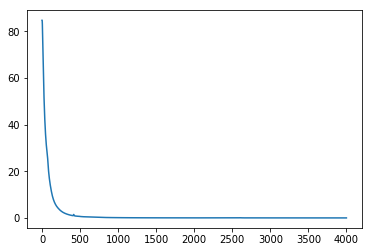

In [11]:
plt.plot(loss_list)
plt.show()

In [12]:
print("Final loss: ", loss_list[-1])

Final loss:  0.010826606303453445


In [13]:
# value to predict a binary input of 8 ones, which should be 255 in decimal
model(torch.ones(1,1,8).cuda())

tensor([[[246.0029]]], device='cuda:0', grad_fn=<ReluBackward0>)

###LSTM

In [0]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM, self).__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(1, x.size(0), self.hidden_dim)).to(device)
        c0 = Variable(torch.zeros(1, x.size(0), self.hidden_dim)).to(device)
        
        
        # One time step
        out, hn = self.lstm(x, (h0, c0))
        out = self.fc(out)
        out = self.ReLU(out)
        return out

In [0]:
num_epoch = 4000

# Create RNN
input_dim = 8   # input dimension
hidden_dim = 64  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 1   # output dimension

#model = RNN(input_dim, hidden_dim, layer_dim, output_dim).to(device)
model = LSTM(input_dim, hidden_dim, layer_dim, output_dim).to(device)

# Mean Squared Error
error = nn.MSELoss()

# SGD Optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)#, momentum=0.9, weight_decay=0.9)

In [23]:
loss_list = []

for epoch in range(num_epoch):
  # Clear gradients
  optimizer.zero_grad()
  
  # Forward propagation
  outputs = model(x)

  #print(outputs)
  #print(y)
  #print(outputs.squeeze(-1).size())
  #print(y.size())
  #break
  
  
  # Calculate softmax and ross entropy loss
  loss = error(outputs, y)
  loss_list.append(loss.item()/256)
  
  # Calculating gradients
  loss.backward()
        
  # Update parameters
  optimizer.step()
  
  # Visualize loss
  print('loss : ',loss.item()/256)

loss :  84.79362487792969
loss :  84.4920654296875
loss :  84.19029998779297
loss :  83.88513946533203
loss :  83.5733871459961
loss :  83.25166320800781
loss :  82.91630554199219
loss :  82.56328582763672
loss :  82.18810272216797
loss :  81.7857666015625
loss :  81.35075378417969
loss :  80.87696838378906
loss :  80.357666015625
loss :  79.78548431396484
loss :  79.15226745605469
loss :  78.44908142089844
loss :  77.66610717773438
loss :  76.79277038574219
loss :  75.81784057617188
loss :  74.7298812866211
loss :  73.51783752441406
loss :  72.17183685302734
loss :  70.6842041015625
loss :  69.05057525634766
loss :  67.27082061767578
loss :  65.34982299804688
loss :  63.29779052734375
loss :  61.130096435546875
loss :  58.86663055419922
loss :  56.530826568603516
loss :  54.148406982421875
loss :  51.746150970458984
loss :  49.350616455078125
loss :  46.987030029296875
loss :  44.678443908691406
loss :  42.4449577331543
loss :  40.3033332824707
loss :  38.266761779785156
loss :  36.34

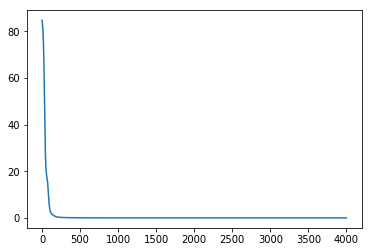

In [24]:
plt.plot(loss_list)
plt.show()

In [25]:
print("Final loss: ", loss_list[-1])

Final loss:  0.000834997626952827


In [26]:
# value to predict a binary input of 8 ones, which should be 255 in decimal
model(torch.ones(1,1,8).cuda())

tensor([[[252.4994]]], device='cuda:0', grad_fn=<ReluBackward0>)